# Introdução

Esse caderno tem por objetivo a criação de um modelo básico de treinamento, utilizando o classificador [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), que faça a predição de homologação de arquivamentos de procedimentos enviados à 1A.CAM do MPF.

Esse modelo usará apenas os metadados dos procedimentos, sem fazer nenhum processamento textual.

O objetivo desse modelo é servir como um *baseline* de comparações para implementações futuras.


**Nota**: os dados desse modelo foram recuperados de procedimentos que tiveram suas deliberações realizadas após o dia 02/07/2018, data em que a nova composição tomou posse na 1A.CAM.

# Carga de dados e pré-processamento

Vamos fazer a carga dos dados e fazer um pré-processamento tradicional (remoção de atributos que não interessam, criação de variáveis categóricas etc.)

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

from sklearn import metrics

In [3]:
PATH = "../data/"
df_original = pd.read_json(f'{PATH}/1A.CAM.homologacao-arquivamento.json')

In [4]:
len(df_original)

8401

In [5]:
df_original.columns

Index(['areaAtuacao', 'classe', 'dataAutuacao', 'dataEntrada', 'homologado',
       'id', 'identificadorPecaPromocao', 'itemCnmp', 'membroResponsavel',
       'municipio', 'prioritario', 'procedimento', 'quantidadeConversoes',
       'quantidadeProvidencias', 'textosProvidencias', 'urgente'],
      dtype='object')

In [6]:
df_original.describe()

,areaAtuacao,classe,homologado,id,identificadorPecaPromocao,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente
count,8.401000e+03,8401.000000,8401.000000,8.401000e+03,7.443000e+03,8.401000e+03,7443.000000,8401.000000,8401.000000,8401.000000,8401.000000,8401.000000
mean,2.403226e+02,2.542912,0.984050,6.885354e+07,8.024042e+07,3.618624e+04,39114.090152,2923.952506,0.007023,2.077372,7.311749,0.007737
std,2.182139e+04,1.460381,0.125291,1.361934e+07,6.839434e+06,2.602520e+05,34816.543692,1670.038202,0.083513,1.460256,8.735195,0.087625
min,1.000000e+00,1.000000,0.000000,2.842880e+06,5.388574e+07,2.000000e+00,752.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+00,2.000000,1.000000,6.441073e+07,7.483514e+07,1.521000e+03,13674.000000,1443.000000,0.000000,1.000000,2.000000,0.000000
50%,2.000000e+00,3.000000,1.000000,7.140668e+07,8.117652e+07,1.581000e+03,25849.000000,3087.000000,0.000000,2.000000,5.000000,0.000000
75%,2.000000e+00,3.000000,1.000000,7.779927e+07,8.650883e+07,1.911000e+03,53328.000000,4385.000000,0.000000,3.000000,9.000000,0.000000
max,2.000085e+06,64.000000,1.000000,8.944926e+07,8.971058e+07,2.007548e+06,128455.000000,5768.000000,1.000000,13.000000,192.000000,1.000000


In [7]:
len(df_original[df_original.identificadorPecaPromocao.isnull()])

958

In [8]:
df_work = df_original.copy()

In [9]:
# elementos com peça de promoção de arquivamento nulos não nos interessam
#df_work.dropna(subset=['identificadorPecaPromocao'], inplace=True)
#df_work.reset_index(drop=True, inplace=True)

In [10]:
#len(df_work[df_work.identificadorPecaPromocao.isnull()])

0

In [9]:
# nessa primeira passada, essas colunas não nos interessam
removed_columns = ['id', 'procedimento', 'textosProvidencias', 'identificadorPecaPromocao']
df_work = df_work.drop(columns=removed_columns)
df_work.sample(10)

,areaAtuacao,classe,dataAutuacao,dataEntrada,homologado,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente
5312,2,2,30-01-2017,11-04-2017,1,2286,26482.0,3281,0,1,2,0
216,2,3,20-11-2015,04-10-2018,1,1811,22991.0,810,0,3,4,0
7616,2,2,05-08-2015,20-04-2016,1,3047,53328.0,170,0,0,1,0
4292,2,3,14-06-2017,09-10-2017,1,1567,6095.0,2584,0,1,3,0
3350,5,2,13-11-2017,12-04-2018,1,1864,53290.0,129,0,1,1,0
1671,2,2,19-02-2018,25-07-2018,1,1543,87480.0,190,0,1,3,0
7703,2,2,18-02-2016,31-03-2016,1,1521,31478.0,3036,0,1,3,0
1587,2,3,14-03-2017,27-07-2018,1,3144,5262.0,3644,0,3,10,0
5545,2,3,02-03-2016,29-03-2017,1,3150,27349.0,4255,0,2,11,0
507,2,2,25-01-2018,18-09-2018,1,3047,127528.0,226,0,3,4,0


In [10]:
df_work.describe()

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente
count,8.401000e+03,8401.000000,8401.000000,8.401000e+03,7443.000000,8401.000000,8401.000000,8401.000000,8401.000000,8401.000000
mean,2.403226e+02,2.542912,0.984050,3.618624e+04,39114.090152,2923.952506,0.007023,2.077372,7.311749,0.007737
std,2.182139e+04,1.460381,0.125291,2.602520e+05,34816.543692,1670.038202,0.083513,1.460256,8.735195,0.087625
min,1.000000e+00,1.000000,0.000000,2.000000e+00,752.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+00,2.000000,1.000000,1.521000e+03,13674.000000,1443.000000,0.000000,1.000000,2.000000,0.000000
50%,2.000000e+00,3.000000,1.000000,1.581000e+03,25849.000000,3087.000000,0.000000,2.000000,5.000000,0.000000
75%,2.000000e+00,3.000000,1.000000,1.911000e+03,53328.000000,4385.000000,0.000000,3.000000,9.000000,0.000000
max,2.000085e+06,64.000000,1.000000,2.007548e+06,128455.000000,5768.000000,1.000000,13.000000,192.000000,1.000000


In [17]:
# tratando os nulos
df_work.fillna(0, inplace=True)

In [11]:
len(df_work[df_work['homologado'] == 1]),len(df_work[df_work['homologado'] == 0])

(8267, 134)

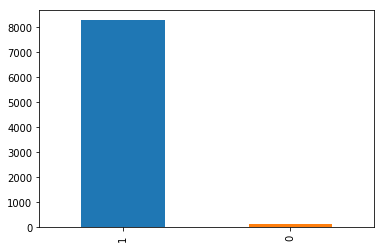

In [12]:
df_work['homologado'].value_counts().plot.bar()

### Classes desbalanceadas!!!

Conforme podemos ver acima, as classes desse problema são altamente desbalanceadas - apenas 1.46% do conjunto de dados representam procedimentos que não foram homologados.

Isso, muito provavelmente, causará problemas no treino do modelo. Mas, inicialmente, vamos ignorar isso e seguir com o nosso treino.

In [13]:
# conversão para datas
df_work['dataAutuacao'] = pd.to_datetime(df_work['dataAutuacao'],infer_datetime_format=True)
df_work['dataEntrada'] = pd.to_datetime(df_work['dataEntrada'],infer_datetime_format=True)

In [14]:
# vamos criar uma variável derivada, representando a quantidade de dias desde a autuação até a entrada
df_work['diasTranscorridos'] = 0
for index in range(len(df_work)):
    df_work.loc[index, 'diasTranscorridos'] =  np.abs((df_work.loc[index, 'dataEntrada'] - df_work.loc[index, 'dataAutuacao']).days)

In [15]:
df_work.sample(10)

,areaAtuacao,classe,dataAutuacao,dataEntrada,homologado,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente,diasTranscorridos
6502,2,2,2016-01-19,2016-11-16,1,3119,96733.0,283,0,2,2,0,302
1586,2,3,2016-08-31,2018-07-30,1,3047,87480.0,170,0,1,6,0,698
1004,2,3,2014-05-30,2018-08-24,1,1582,27026.0,1996,0,5,16,0,1547
2938,2,3,2014-08-26,2018-05-16,1,1580,31458.0,3551,0,4,13,0,1359
7971,6,2,2015-01-20,2016-02-03,1,3047,87545.0,501,0,2,6,0,379
892,2,2,2018-01-25,2018-08-30,1,1560,3768.0,1214,0,2,4,0,217
4667,2,3,2014-08-04,2017-07-21,1,1501,87523.0,5094,0,3,6,0,1082
7180,2,3,2014-10-08,2016-06-29,1,726,53319.0,3533,0,4,11,0,630
4765,5,2,2016-11-21,2017-07-11,1,750,64218.0,1541,1,2,5,1,232
7453,2,2,2015-11-18,2016-05-23,1,1514,17663.0,5459,0,2,2,0,187


In [18]:
removed_columns = ['homologado', 'dataEntrada', 'dataAutuacao']
features = [c for c in df_work.columns if c not in removed_columns]

model = RandomForestClassifier(random_state=42)
model.fit(df_work[features], df_work['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [19]:
model.score(df_work[features], df_work['homologado'])

0.997738364480419

In [20]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df_work, random_state=42)
train.shape, valid.shape

((6300, 13), (2101, 13))

In [21]:
model.fit(train[features], train['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [22]:
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_score():
    print('Accuracy score:', accuracy_score(train['homologado'], train_preds), accuracy_score(valid['homologado'], valid_preds))
    print('Precision score: ', format(precision_score(valid['homologado'], valid_preds)))
    print('Recall score: ', format(recall_score(valid['homologado'], valid_preds)))
    print('F1 score: ', format(f1_score(valid['homologado'], valid_preds)))

print_score()

Accuracy score: 0.9984126984126984 0.9871489766777725
Precision score:  0.987613149118628
Recall score:  0.9995178399228544
F1 score:  0.99352983465133


### Primeira avaliação

Embora não tenha ocorrido overfitting no treinamento e o *score* final tenha sido alto, cabe utilizar uma outra medida para assegurar a qualidade do modelo. Vamos utilizar a ** *matriz de confusão* **.



In [24]:
from sklearn.metrics import confusion_matrix

confusion_matrix(valid['homologado'], valid_preds)

array([[   1,   26],
       [   1, 2073]])

In [34]:
len(valid[valid['homologado']==1]), len(valid[valid['homologado']==0])

(2074, 27)

Ao utilizar o ravel(), temos uma saída do tipo (tn, fp, fn, tp). De onde vemos que:


- tivemos 0 tn - *true negative*; ou seja, o modelo não acertou **nenhum** dos que não tiveram o arquivamento homologado;
- tivemos 28 fp - *false positive*; 28 que não tiveram o arquivamento não homologado e o modelo classificou como homologado;
- tivemos 0 fn - *false negative*; foram homologados e o modelo marcou como não homologados;
- tivemos 1952 tp - *true positive*; foram homologados e o modelo marcou corretamente.

Logo, apesar da acurácia do modelo aparentar ser muito boa (98% no validation set), o **modelo não sabe lidar com os não arquivamentos** - não acertou nenhum dos que realmente não foram homologados. Ou seja dos 28 que não foram homologados, o modelo errou todos.

Fica claro que somente essas features não ajudam na descoberta - o texto da íntegra é, segundo a área negocial, realmente o mais importante.

Vamos continuar avaliando esse modelo.

## Feature importances

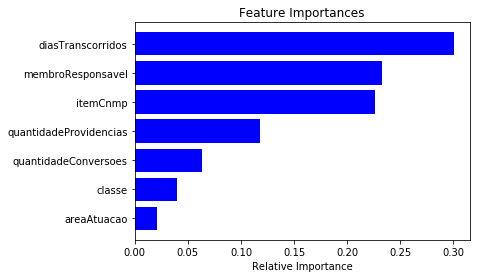

In [35]:
import matplotlib.pyplot as plt

def plot_fi(feature_importances, size=None):
    feature_importances = model.feature_importances_
    
    if not size:
        size = len(feature_importances)
    
    indices = np.argsort(feature_importances[0:size])
    
    plt.title('Feature Importances')
    plt.barh(range(size), feature_importances[indices], color='b', align='center')
    plt.yticks(range(size), [features[i] for i in indices if i < size])
    plt.xlabel('Relative Importance')
    plt.show()
    
plot_fi(model.feature_importances_)

O modelo está dando muita importância ao município que, considerando o bom senso e um pouco de domínio negocial, não faz sentido - o município não deveria interferir.

Lembrar: criar uma coluna para cada uma das listas de palavras-chaves, indicando ausência ou presença

In [36]:
# Vou retirar as colunas com poucas importância
removed_columns = ['homologado', 'dataEntrada', 'dataAutuacao', 'urgente', 'prioritario']
features = [c for c in df_work.columns if c not in removed_columns]

model = RandomForestClassifier(random_state=42)

model.fit(train[features], train['homologado'])

train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9985714285714286 0.985721085197525
Precision score:  0.9871306005719733
Recall score:  0.9985535197685632
F1 score:  0.9928092042186002


In [37]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   3, 2071]])

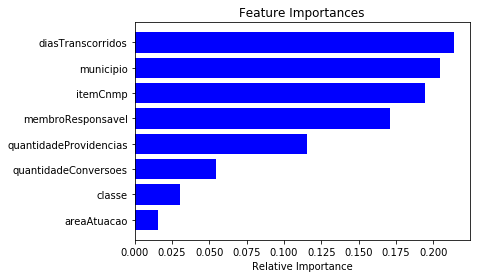

In [38]:
plot_fi(model.feature_importances_)

Com as novas features, retirando a urgente e a prioritário, não houve melhorias.

Vou retirar a coluna município, pois, ao meu ver, ela não nos parece adequada - e o modelo continua dando muita importância a ela.

In [39]:
removed_columns.append('municipio')
removed_columns

features = [c for c in df_work.columns if c not in removed_columns]

model.fit(train[features], train['homologado'])

train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9984126984126984 0.9861970490242742
Precision score:  0.9876013352408202
Recall score:  0.9985535197685632
F1 score:  0.9930472308798849


In [40]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   1,   26],
       [   3, 2071]])

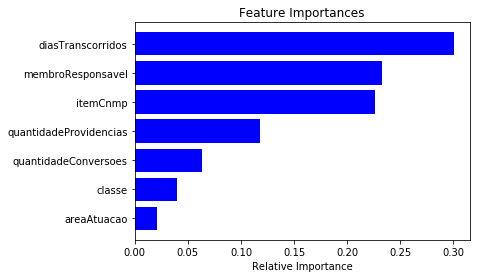

In [41]:
plot_fi(model.feature_importances_)

Ao retirar a coluna município, fez com que aparece um true negative e um false positive.

Vamos criar um modelo ainda mais simples, apenas com as features cuja importância seja maior que 5%.

In [42]:
model = RandomForestClassifier(random_state=42)

important_features = ['membroResponsavel', 'diasTranscorridos', 'itemCnmp', 'quantidadeProvidencias', 'quantidadeConversoes']
model.fit(train[important_features], train['homologado'])

train_preds = model.predict(train[important_features])
valid_preds = model.predict(valid[important_features])

print_score()

Accuracy score: 0.9984126984126984 0.985721085197525
Precision score:  0.9871306005719733
Recall score:  0.9985535197685632
F1 score:  0.9928092042186002


In [43]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   3, 2071]])

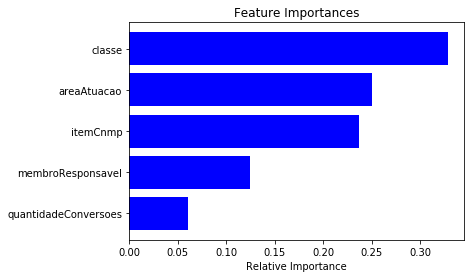

In [44]:
plot_fi(model.feature_importances_)

Somente com as features importantes acima, o desempenho se manteve. 

Interessante notar que a variável diasTranscorridos desapereceu da lista de importâncias.

Vamos fazer mais um teste, apenas com as top-3 features

In [45]:
important_features = ['classe', 'areaAtuacao', 'itemCnmp']

model = RandomForestClassifier(random_state=42)
model.fit(train[important_features], train['homologado'])

train_preds = model.predict(train[important_features])
valid_preds = model.predict(valid[important_features])

print_score()

Accuracy score: 0.9865079365079366 0.9809614469300333
Precision score:  0.987535953978907
Recall score:  0.9932497589199615
F1 score:  0.9903846153846154


In [46]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   1,   26],
       [  14, 2060]])

Com o modelo mais simples, a acurácia caiu e apareceram false negatives. 

Fica claro que não sabe lidar com os não homologados.

Vamos passar a considerar o texto das providências.

## Considerando as providências realizadas

In [47]:
df_work = df_original.copy()

df_work['dataAutuacao'] = pd.to_datetime(df_work['dataAutuacao'],infer_datetime_format=True)
df_work['dataEntrada'] = pd.to_datetime(df_work['dataEntrada'],infer_datetime_format=True)

df_work['diasTranscorridos'] = 0
for index in range(len(df_work)):
    df_work.loc[index, 'diasTranscorridos'] =  np.abs((df_work.loc[index, 'dataEntrada'] - df_work.loc[index, 'dataAutuacao']).days)

removed_columns = ['id', 'procedimento', 'identificadorPecaPromocao', 'prioritario', 'urgente', 'dataAutuacao', 'dataEntrada']
df_work = df_work.drop(columns=removed_columns)
df_work.fillna(0, inplace=True)

    
df_work.sample(10)

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,textosProvidencias,diasTranscorridos
7019,2,3,1,1598,13959.0,3445,3,8,"Converta-se em Inquérito Civil(IC).,Analisar A...",496
1187,2,3,1,3078,31406.0,1214,3,5,"Converta-se em Inquérito Civil(IC).,Oficie-se,...",1064
2065,2,3,1,1504,14143.0,3383,2,9,"Interpor recurso no MPF.,Converta-se em Inquér...",1174
2947,2,5,1,3078,127528.0,226,1,1,Prorroga-se o prazo de finalização do Procedim...,777
5460,2,3,1,1560,5523.0,3113,3,25,"Converta-se em Inquérito Civil(IC).,Junte-se.,...",854
7690,2,2,1,1523,0.0,3113,2,5,"Oficie-se.,Prorroga-se o prazo de finalização ...",315
3758,2,2,1,1521,18836.0,3113,2,5,"Oficie-se.,Prorroga-se o prazo de finalização ...",448
8112,2,2,1,2104,0.0,3689,0,1,Oficie-se.,34
564,2,3,1,1580,11692.0,3689,4,12,"Converta-se em Inquérito Civil(IC).,Oficie-se....",709
3854,2,2,1,1658,11289.0,1541,1,5,"Oficie-se.,Converta-se em Procedimento Prepara...",130


In [48]:
df_work.describe()

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,diasTranscorridos
count,8.401000e+03,8401.000000,8401.000000,8.401000e+03,8401.000000,8401.000000,8401.000000,8401.000000,8401.000000
mean,2.403226e+02,2.542912,0.984050,3.618624e+04,34653.752291,2923.952506,2.077372,7.311749,581.627068
std,2.182139e+04,1.460381,0.125291,2.602520e+05,35050.392009,1670.038202,1.460256,8.735195,613.894433
min,1.000000e+00,1.000000,0.000000,2.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000e+00,2.000000,1.000000,1.521000e+03,8883.000000,1443.000000,1.000000,2.000000,174.000000
50%,2.000000e+00,3.000000,1.000000,1.581000e+03,23212.000000,3087.000000,2.000000,5.000000,343.000000
75%,2.000000e+00,3.000000,1.000000,1.911000e+03,53307.000000,4385.000000,3.000000,9.000000,789.000000
max,2.000085e+06,64.000000,1.000000,2.007548e+06,128455.000000,5768.000000,13.000000,192.000000,5823.000000


In [49]:
listaProvidencias = []
for index in range(len(df_work)):
    for s in str(df_work['textosProvidencias'][index]).strip().lower().split(','):
        listaProvidencias.append(s)

listaProvidencias = set(listaProvidencias)
listaProvidencias.remove('análise do arquivamento')
listaProvidencias.remove('analisar arquivamento')
listaProvidencias.remove('arquive-se na unidade.')

In [50]:
df_work = pd.concat([df_work, pd.get_dummies(sorted(list(listaProvidencias)), drop_first=True)], axis=1)

In [51]:
for index in range(len(df_work)):
    for s in str(df_work.textosProvidencias[index]).strip().split(','):
        df_work.at[index, s.lower()] = 1

In [52]:
df_work.describe()

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,diasTranscorridos,analisar conflito de atribuição,...,recomende-se.,redistribua-se.,requisite-se perícia à ccr/mpf.,sobrestar no setor.,solicitar instauração de inquérito judicial,vistoria,análise do arquivamento,analisar arquivamento,arquive-se na unidade.,
count,8.401000e+03,8401.000000,8401.000000,8.401000e+03,8401.000000,8401.000000,8401.000000,8401.000000,8401.000000,137.000000,...,737.000000,809.000000,89.000000,1022.000000,74.000000,86.000000,238.0,886.0,159.0,175.0
mean,2.403226e+02,2.542912,0.984050,3.618624e+04,34653.752291,2923.952506,2.077372,7.311749,581.627068,0.481752,...,0.910448,0.927070,0.191011,0.946184,0.027027,0.162791,1.0,1.0,1.0,1.0
std,2.182139e+04,1.460381,0.125291,2.602520e+05,35050.392009,1670.038202,1.460256,8.735195,613.894433,0.501501,...,0.285733,0.260182,0.395325,0.225765,0.163269,0.371340,0.0,0.0,0.0,0.0
min,1.000000e+00,1.000000,0.000000,2.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0
25%,2.000000e+00,2.000000,1.000000,1.521000e+03,8883.000000,1443.000000,1.000000,2.000000,174.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0
50%,2.000000e+00,3.000000,1.000000,1.581000e+03,23212.000000,3087.000000,2.000000,5.000000,343.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0
75%,2.000000e+00,3.000000,1.000000,1.911000e+03,53307.000000,4385.000000,3.000000,9.000000,789.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0
max,2.000085e+06,64.000000,1.000000,2.007548e+06,128455.000000,5768.000000,13.000000,192.000000,5823.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0


In [53]:
df_work.head()

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,textosProvidencias,diasTranscorridos,...,recomende-se.,redistribua-se.,requisite-se perícia à ccr/mpf.,sobrestar no setor.,solicitar instauração de inquérito judicial,vistoria,análise do arquivamento,analisar arquivamento,arquive-se na unidade.,
0,2,3,1,1708,10687.0,810,3,6,"Converta-se em Inquérito Civil(IC).,Oficie-se....",383,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2,3,1,1503,96733.0,253,8,16,"Prorroga-se Expediente.,Justificativa para fin...",2520,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2,2,1,1521,31435.0,3193,3,7,"Despacho Simplificado,Oficie-se.,Prorroga-se o...",328,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,2,3,1,1580,5262.0,3422,7,31,"Apense-se.,Sobrestar no setor.,Notifique-se.,O...",3085,...,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
4,2,2,1,1507,87450.0,4842,3,15,"Sobrestar no setor.,Oficie-se.,Prorroga-se o p...",225,...,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN


In [54]:
df_work.fillna(0, inplace=True)

In [55]:
removed_columns = ['homologado', 'textosProvidencias']
features = [c for c in df_work.columns if c not in removed_columns]

In [56]:
train, valid = train_test_split(df_work, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(train[features], train['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [57]:
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9987301587301587 0.9866730128510233
Precision score:  0.9871428571428571
Recall score:  0.9995178399228544
F1 score:  0.9932918064206996


In [58]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   1, 2073]])

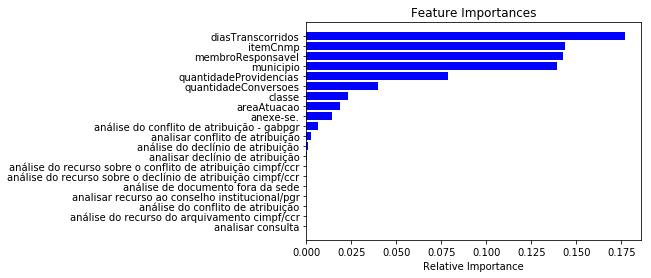

In [59]:
plot_fi(model.feature_importances_, 20)

O uso dos textos das providências não aumentou a precisão do modelo (e elas também não foram features importantes).

Vamos voltar ao modelo mais simples, sem os textos das providências e tentar melhorar os hiperparâmetros.

## Voltando ao modelo mais simples (sem considerar quais providências foram realizadas)

In [60]:
df_work = df_original.copy()

df_work['dataAutuacao'] = pd.to_datetime(df_work['dataAutuacao'],infer_datetime_format=True)
df_work['dataEntrada'] = pd.to_datetime(df_work['dataEntrada'],infer_datetime_format=True)

df_work['diasTranscorridos'] = 0
for index in range(len(df_work)):
    df_work.loc[index, 'diasTranscorridos'] =  np.abs((df_work.loc[index, 'dataEntrada'] - df_work.loc[index, 'dataAutuacao']).days)

removed_columns = ['id', 'procedimento', 'identificadorPecaPromocao', 'prioritario', 'urgente', 'dataAutuacao', 'dataEntrada']
df_work = df_work.drop(columns=removed_columns)
df_work.fillna(0, inplace=True)

    
df_work.sample(10)

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,textosProvidencias,diasTranscorridos
4013,2,2,1,1556,11396.0,3520,2,2,"Prorroga-se Expediente.,Converta-se em Procedi...",413
482,2,3,1,1030,17137.0,3689,1,12,"Encaminhe-se o auto.,Converta-se em Inquérito ...",468
2306,2,3,1,1567,127555.0,5108,4,17,"Desapense-se.,Encaminhe-se o auto.,Apense-se.,...",1969
4570,2,2,1,734,17154.0,4387,1,5,"Despacho Simplificado,Oficie-se.,Converta-se e...",169
5643,2,2,1,2338,25849.0,3955,1,3,"Oficie-se.,Converta-se em Procedimento Prepara...",113
404,2,3,1,2359,13550.0,3674,4,15,"Converta-se em Inquérito Civil(IC).,Oficie-se....",1420
770,2,3,1,2006468,17164.0,5111,4,15,"Encaminhe-se o auto.,Converta-se em Inquérito ...",1402
1219,2,2,1,697,53321.0,3573,3,7,"Despacho Simplificado,Oficie-se.,Prorroga-se o...",250
4521,2,5,1,1556,127551.0,1819,0,3,Oficie-se.,194
7423,2,3,1,750,3537.0,1443,1,1,Converta-se em Inquérito Civil(IC).,164


In [61]:
removed_columns = ['homologado', 'textosProvidencias']
features = [c for c in df_work.columns if c not in removed_columns]

train, valid = train_test_split(df_work, random_state=42)

In [62]:
model = RandomForestClassifier(random_state=42, n_estimators=100); model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [63]:
model.fit(train[features], train['homologado'])

train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9998412698412699 0.9876249405045217
Precision score:  0.9876190476190476
Recall score:  1.0
F1 score:  0.9937709631049353


In [64]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   1,   26],
       [   0, 2074]])

### Aumentando o número de árvores

In [65]:
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9998412698412699 0.9876249405045217
Precision score:  0.9876190476190476
Recall score:  1.0
F1 score:  0.9937709631049353


In [66]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   1,   26],
       [   0, 2074]])

In [67]:
model = RandomForestClassifier(random_state=42, n_estimators=1000)
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 1.0 0.9871489766777725
Precision score:  0.9871489766777725
Recall score:  1.0
F1 score:  0.9935329341317366


In [68]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   0, 2074]])

In [69]:
model = RandomForestClassifier(random_state=42, n_estimators=2000)
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 1.0 0.9871489766777725
Precision score:  0.9871489766777725
Recall score:  1.0
F1 score:  0.9935329341317366


In [70]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   0, 2074]])

Aumentar o número de árvores parece não melhorar a performance. Vamos para o número de features.

### Considerando o número de features

In [71]:
model = RandomForestClassifier(random_state=42); model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [73]:
model.fit(train[features], train['homologado'])
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9985714285714286 0.985721085197525
Precision score:  0.9871306005719733
Recall score:  0.9985535197685632
F1 score:  0.9928092042186002


In [74]:
model = RandomForestClassifier(random_state=42, max_features='sqrt')
model.fit(train[features], train['homologado'])
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9985714285714286 0.985721085197525
Precision score:  0.9871306005719733
Recall score:  0.9985535197685632
F1 score:  0.9928092042186002


In [75]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   3, 2071]])

In [76]:
model = RandomForestClassifier(random_state=42, max_features='log2')
model.fit(train[features], train['homologado'])
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9984126984126984 0.9861970490242742
Precision score:  0.9871367317770366
Recall score:  0.9990356798457087
F1 score:  0.993050563144021


In [77]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   2, 2072]])

In [78]:
model = RandomForestClassifier(random_state=42, max_features=0.3)
model.fit(train[features], train['homologado'])
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9985714285714286 0.985721085197525
Precision score:  0.9871306005719733
Recall score:  0.9985535197685632
F1 score:  0.9928092042186002


In [79]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   3, 2071]])

O parâmetro max_features parece não melhorar a performance. Vamos para o min_samples_leaf.

### Checando o min_samples_leaf

In [80]:
model = RandomForestClassifier(random_state=42); model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [81]:
model.fit(train[features], train['homologado'])
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9985714285714286 0.985721085197525
Precision score:  0.9871306005719733
Recall score:  0.9985535197685632
F1 score:  0.9928092042186002


In [82]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   3, 2071]])

In [83]:
model = RandomForestClassifier(random_state=42, min_samples_leaf=2)
model.fit(train[features], train['homologado'])
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9846031746031746 0.9871489766777725
Precision score:  0.9871489766777725
Recall score:  1.0
F1 score:  0.9935329341317366


In [84]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   0, 2074]])

In [85]:
model = RandomForestClassifier(random_state=42, min_samples_leaf=5)
model.fit(train[features], train['homologado'])
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.983015873015873 0.9871489766777725
Precision score:  0.9871489766777725
Recall score:  1.0
F1 score:  0.9935329341317366


In [86]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   0, 2074]])

In [87]:
model = RandomForestClassifier(random_state=42, min_samples_leaf=10)
model.fit(train[features], train['homologado'])
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.983015873015873 0.9871489766777725
Precision score:  0.9871489766777725
Recall score:  1.0
F1 score:  0.9935329341317366


In [88]:
confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   0, 2074]])

Uma vez mais, não houve melhoria no modelo ao tentar modificar o min_samples_leaf.

Vamos tentar uma última coisa, que é lidar com o fato de as classes serem desbalanceadas.

## Lidando com as classes desbalanceadas

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/